In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# This code snippet improves the way text is handled in matplotlib
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.sans-serif"] = "Helvetica"

### Initializing a CAVEclient

Note: You need a simple, free registration to enable programmatic access to the dataset. See the Setup tutorial for instructions on how to complete the authentication and client setup.

In [2]:
# Initialize a CAVEclient for the Minnie65 dataset

from caveclient import CAVEclient

client = CAVEclient('minnie65_public_v117')

### Figure 5b: Listing available data tables.

In [3]:
# List all tables available
tables = client.materialize.get_tables()
tables

['nucleus_detection_v0',
 'synapses_pni_2',
 'nucleus_neuron_svm',
 'proofreading_status_public_release',
 'func_unit_em_match_release',
 'allen_soma_ei_class_model_v1',
 'allen_visp_column_soma_coarse_types_v1']

Metadata for each table can be retrived as well, including a long form description of the data in the table.

In [4]:
client.materialize.get_table_metadata('synapses_pni_2')

{'created': '2020-11-04T06:48:36.953637',
 'table_name': 'synapses_pni_2',
 'id': 16,
 'aligned_volume': 'minnie65_phase3',
 'valid': True,
 'schema': 'synapse',
 'user_id': '304',
 'reference_table': '',
 'schema_type': 'synapse',
 'description': 'Automated synapse detection performed by Nick Turner from the Seung Lab.  size represents the number of (4x4x40 nm) voxels painted by the automated cleft segmentation, and the IDs reference the IDs of the cleft segmentation.  Ctr_pt reflects the centroid of the cleft segmentation. The cleft segmentation volume is located in the flat_segmentation_source field. ',
 'flat_segmentation_source': 'precomputed://s3://bossdb-open-data/microns/minnie/minnie65-phase3-ws/clefts/v0/clefts',
 'voxel_resolution': [4.0, 4.0, 40.0]}

### Figure 5c: Inhibitory and Excitatory Neurons

For this panel, we visualized data from both the neuron/not neuron classifier table (`nucleus_neuron_svm`) and the predicted E/I neuronal cell types table (`allen_soma_ei_class_model_v1`).

In [5]:
is_neuron_df = client.materialize.query_table('nucleus_neuron_svm')
ei_df = client.materialize.query_table('allen_soma_ei_class_model_v1')

Each row has cell type information, a root id for the object, and a representative point that comes from the centroid of the cell's nucleus.

In [6]:
is_neuron_df.head()

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,348209,t,is_neuron,not-neuron,92423916840203243,864691134945836023,"[200928, 282512, 16717]"
1,640071,t,is_neuron,not-neuron,0,0,"[371696, 98672, 19791]"
2,462557,t,is_neuron,not-neuron,101417167182010351,864691135294515893,"[266304, 178832, 25200]"
3,266849,t,is_neuron,not-neuron,88330641678196634,864691135974582895,"[171184, 194128, 20082]"
4,219514,t,is_neuron,not-neuron,85994867133853165,864691135644554735,"[154480, 92528, 23737]"


The `pt_position` location is in voxel units, not physical units. To convert to physical units, the table metadata has the x, y, and z resolution in nm per voxel. All tables are using the same voxel resolution, so we reuse the values here. For visualization purposes, we add the x, y, and z coordinates in microns to the dataframe.

In [7]:
voxel_resolution = client.materialize.get_table_metadata('nucleus_neuron_svm')['voxel_resolution']

is_neuron_df['pt_position_x_um'] = np.vstack(is_neuron_df['pt_position'])[:,0] * voxel_resolution[0] / 1000 
is_neuron_df['pt_position_y_um'] = np.vstack(is_neuron_df['pt_position'])[:,1] * voxel_resolution[1] / 1000 
is_neuron_df['pt_position_z_um'] = np.vstack(is_neuron_df['pt_position'])[:,2] * voxel_resolution[2] / 1000

ei_df['pt_position_x_um'] = np.vstack(ei_df['pt_position'])[:,0] * voxel_resolution[0] / 1000 
ei_df['pt_position_y_um'] = np.vstack(ei_df['pt_position'])[:,1] * voxel_resolution[1] / 1000 
ei_df['pt_position_z_um'] = np.vstack(ei_df['pt_position'])[:,2] * voxel_resolution[2] / 1000

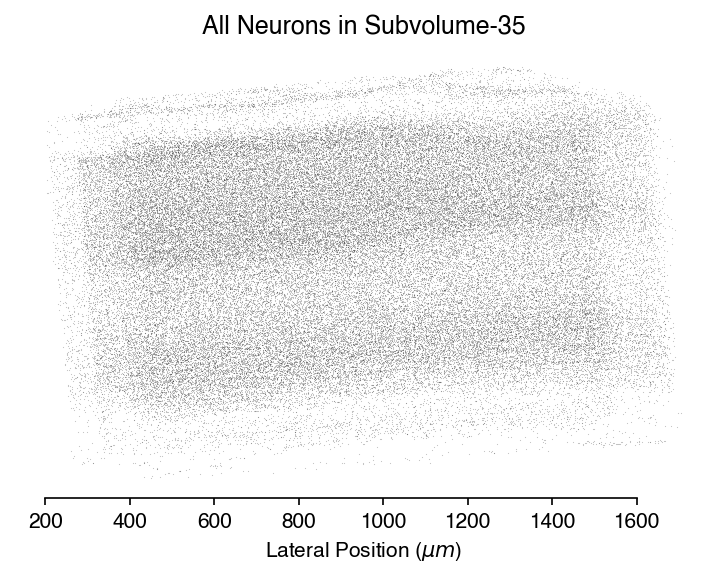

In [8]:
fig, ax = plt.subplots(figsize=(6,4), dpi=150)

sns.scatterplot(
    x='pt_position_x_um',
    y='pt_position_y_um',
    color='k',
    s=0.3,
    alpha=0.25,
    ax=ax,
    data=is_neuron_df.query('cell_type == "neuron"')
)

ax.invert_yaxis()  # The y axis increases from pia toward white matter.
ax.set_aspect('equal')
ax.yaxis.set_visible(False)
sns.despine(ax=ax, left=True, right=True, top=True, trim=True)

ax.set_title('All Neurons in Subvolume-35')
_=ax.set_xlabel('Lateral Position ($\mu m$)')

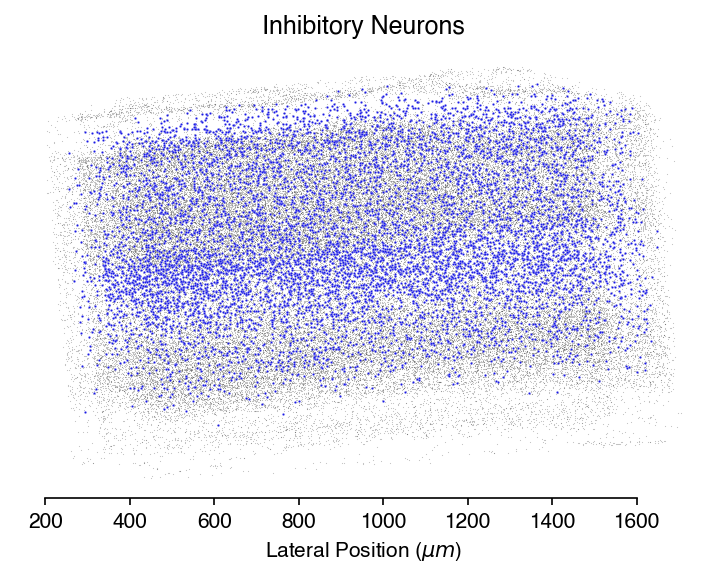

In [9]:
fig, ax = plt.subplots(figsize=(6,4), dpi=150)

sns.scatterplot(
    x='pt_position_x_um',
    y='pt_position_y_um',
    color='k',
    s=0.3,
    alpha=0.25,
    ax=ax,
    data=is_neuron_df.query('cell_type == "neuron"')
)

sns.scatterplot(
    x='pt_position_x_um',
    y='pt_position_y_um',
    s=1.25,
    alpha=1,
    data=ei_df.query('cell_type=="inhibitory"'), # Only show inhibitory neurons
    legend=False,
    color=(0.1,0.1,0.9),
    edgecolor='w',
)

ax.invert_yaxis()  # The y axis increases from pia toward white matter.
ax.set_aspect('equal')
ax.yaxis.set_visible(False)
sns.despine(ax=ax, left=True, right=True, top=True, trim=True)

ax.set_title('Inhibitory Neurons')
_=ax.set_xlabel('Lateral Position ($\mu m$)')

### Figure 5d: Proofread Neurons

For this panel, we visualized data from the proofreading table (`proofreading_status_public_release`), as well as the same background neuron locations from in panel 5c.

In [10]:
pf_df = client.materialize.query_table('proofreading_status_public_release')

#  As above, we first transform position columns
pf_df['pt_position_x_um'] = np.vstack(pf_df['pt_position'])[:,0] * voxel_resolution[0] / 1000 
pf_df['pt_position_y_um'] = np.vstack(pf_df['pt_position'])[:,1] * voxel_resolution[1] / 1000 
pf_df['pt_position_z_um'] = np.vstack(pf_df['pt_position'])[:,2] * voxel_resolution[2] / 1000

The proofreading table includes a status for the axon and the dendrites separately. Different project goals have demanded different degrees of proofreading. The three conditions we describe are:
* `non` : The compartment has not been comprehensively proofread. This does not necessarily mean that no edits have happened, just that a full round of proofreading has not happened.
* `clean` : The compartment has been fully checked for false merges. This means that the arbor is correct, even if potentially incomplete. Often some extensions have been added to such cells, but not to completion.
* `extended` : The compartment has been cleaned of false merges and extended as far possible within the Minnie65 subvolume.

In [11]:
pf_df.head(5)

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position,pt_position_x_um,pt_position_y_um,pt_position_z_um
0,1,t,89529934389098311,864691136296964635,864691136296964635,extended,non,"[179808, 216672, 23361]",719.232,866.688,934.44
1,2,t,90584228533843146,864691136311986237,864691136311986237,extended,non,"[187840, 207232, 22680]",751.360,828.928,907.20
2,3,t,89528353773943370,864691135355207119,864691135355207119,extended,non,"[180016, 204592, 22798]",720.064,818.368,911.92
3,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[191424, 209888, 22845]",765.696,839.552,913.80
4,5,t,88897234233461709,864691136422983727,864691136422983727,extended,non,"[175248, 220944, 23561]",700.992,883.776,942.44


For visualization purposes, we generate a single category definition from the two states.

In [12]:
category_title = {
    'extended': {'extended': 'Complete', 'clean': 'Clean', 'non': 'Dendrite-only'},
    'clean': {'extended': 'Clean', 'clean': 'Clean', 'non': 'Non'},
    'non': {'extended': 'Non', 'clean': 'Non', 'non': 'Non'},
}

def get_cat(row):
    return category_title[row['status_dendrite']][row['status_axon']]

pf_df['title'] = pf_df.apply(get_cat, axis=1)

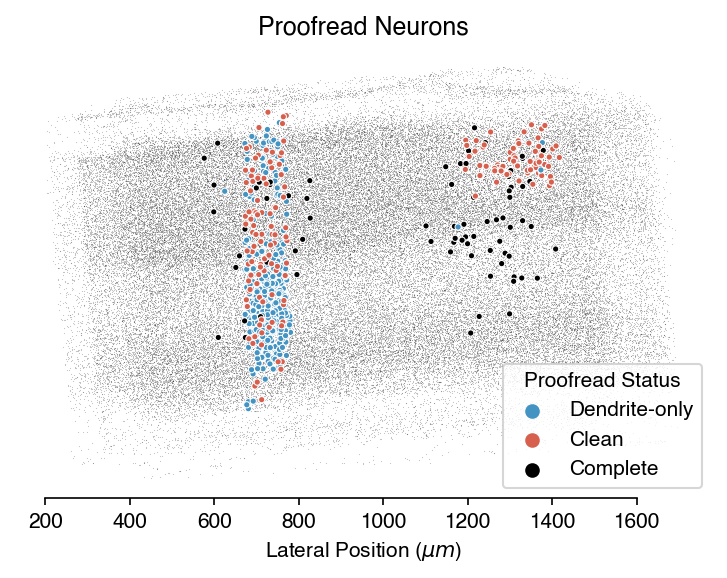

In [13]:
clean_color = (0.8392156862745098, 0.3764705882352941, 0.30196078431372547)
dend_color = (0.2627450980392157, 0.5764705882352941, 0.7647058823529411)

fig, ax = plt.subplots(figsize=(6,4), dpi=150)

sns.scatterplot(
    x='pt_position_x_um',
    y='pt_position_y_um',
    color='k',
    s=0.3,
    alpha=0.25,
    ax=ax,
    data=is_neuron_df.query('cell_type == "neuron"')
)

sns.scatterplot(
    x='pt_position_x_um',
    y='pt_position_y_um',
    hue='title',
    s=9,
    alpha=1,
    data=pf_df,
    hue_order=('Dendrite-only', 'Clean', 'Complete'),
    palette={'Complete': [0,0,0], 'Clean': clean_color, 'Dendrite-only': dend_color},
    edgecolor='w',
    linewidth=0.5,
)

ax.invert_yaxis()  # The y axis increases from pia toward white matter.
ax.set_aspect('equal')
ax.yaxis.set_visible(False)
sns.despine(ax=ax, left=True, right=True, top=True, trim=True)
ax.legend().set_title('Proofread Status')
ax.set_title('Proofread Neurons')
_=ax.set_xlabel('Lateral Position ($\mu m$)')

### Figure 5d: Functionally-matched Neurons

For this panel, we visualized data from the preliminary release of the functional matching table (`proofreading_status_public_release`), as well as the same background neuron locations from in panel 5c.

In [14]:
coreg_df = client.materialize.query_table('func_unit_em_match_release')

#  As above, we first transform position columns
coreg_df['pt_position_x_um'] = np.vstack(coreg_df['pt_position'])[:,0] * voxel_resolution[0] / 1000 
coreg_df['pt_position_y_um'] = np.vstack(coreg_df['pt_position'])[:,1] * voxel_resolution[1] / 1000 
coreg_df['pt_position_z_um'] = np.vstack(coreg_df['pt_position'])[:,2] * voxel_resolution[2] / 1000

Note that each row of the functional matching table contains a session, scan, and unit id that together uniquely identify a functional trace that can be queried in DataJoint.

In [15]:
coreg_df.head()

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,pt_position,pt_position_x_um,pt_position_y_um,pt_position_z_um
0,1,t,111892900580825107,864691135771728459,9,4,5443,"[342768, 110096, 16982]",1371.072,440.384,679.28
1,2,t,113374561219162796,864691136056503512,5,6,4163,"[353824, 139168, 17340]",1415.296,556.672,693.60
2,3,t,114151228744823805,864691135759645885,6,6,6173,"[359104, 158528, 16988]",1436.416,634.112,679.52
3,4,t,113591508741325495,864691136023817529,7,4,12641,"[355312, 182976, 18283]",1421.248,731.904,731.32
4,5,t,113101126421131388,864691135847929438,5,6,8571,"[351568, 199024, 17264]",1406.272,796.096,690.56


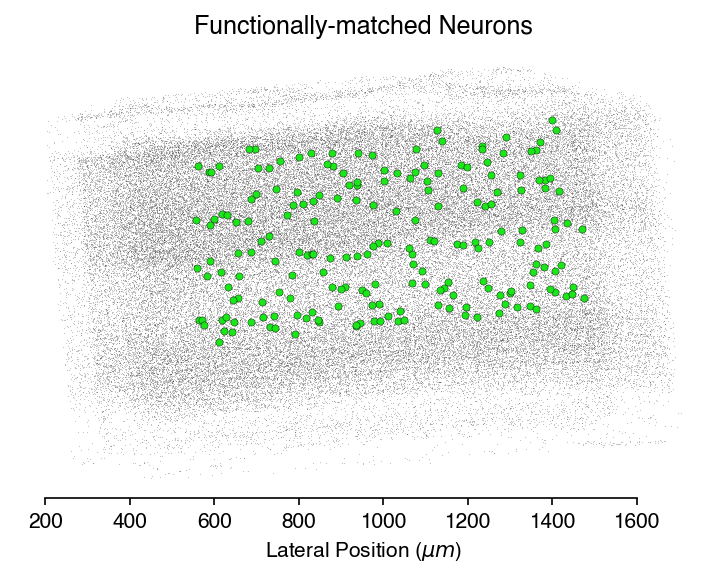

In [16]:
fig, ax = plt.subplots(figsize=(6,4), dpi=150)

sns.scatterplot(
    x='pt_position_x_um',
    y='pt_position_y_um',
    color='k',
    s=0.3,
    alpha=0.25,
    ax=ax,
    data=is_neuron_df.query('cell_type == "neuron"')
)


sns.scatterplot(
    x='pt_position_x_um',
    y='pt_position_y_um',
    s=12,
    alpha=1,
    data=coreg_df,
    legend=False,
    color=(0.1,0.9,0.1),
    edgecolor='k',
    linewidth=0.2,
)

ax.invert_yaxis()  # The y axis increases from pia toward white matter.
ax.set_aspect('equal')
ax.yaxis.set_visible(False)
sns.despine(ax=ax, left=True, right=True, top=True, trim=True)
ax.set_title('Functionally-matched Neurons')
_=ax.set_xlabel('Lateral Position ($\mu m$)')

### Figure 5f — A neuron and its synapses

In this section, we find a proofread neuron that will serve as the seed for exploring the local network.

In [17]:
# An object's root id is a unique identifier across the EM analysis data.
# Here, we take the one of the fully proofread cells that has been extended.
# You can get any of the 78 root ids that were labeled complete above.

seed_id = 864691134988768122

To download meshes, we need to use cloudvolume (or MeshParty, which uses cloudvolume under the hood). Note that cloudvolume requires that you have saved an authentication token when setting up your environment.

In [18]:
import cloudvolume
from meshparty import trimesh_io

# The following offers the most robust way to download a mesh, and necessary in this case.

cv = cloudvolume.CloudVolume(
    client.info.segmentation_source(),
    progress=False,
    use_https=True,
)

seed_mesh_cv = cv.mesh.get(seed_id, use_byte_offsets=True)
seed_mesh = trimesh_io.Mesh(
    vertices=seed_mesh_cv[seed_id].vertices,
    faces=seed_mesh_cv[seed_id].faces,
)

To get the synapses for this neuron, we can use a different client function. We need to do the query once for presynaptic 

In [19]:
pre_syn_df = client.materialize.synapse_query(pre_ids=seed_id)
post_syn_df = client.materialize.synapse_query(post_ids=seed_id)

# How many synapses does this cell actually have in total?
print('Synaptic outputs:', len(pre_syn_df), '\nSynaptic inputs:', len(post_syn_df))

Synaptic outputs: 1398 
Synaptic inputs: 3441


Each row of the synapse table describes a synapse, including both pre- and postsynaptic root ids as well as locations on either side of the synapse and one at the interface (`ctr_pt_position`). We typically plot ctr_point_position, which is the closest point to mesh faces.

In [20]:
pre_syn_df.head()

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,101855461,t,84941603579593339,864691134988768122,84871234835427792,864691132852281829,2980,"[146470, 109634, 22711]","[146384, 109666, 22707]","[146420, 109648, 22708]"
1,167308498,t,89729908402009084,864691134988768122,89729908402034650,864691135373903602,10312,"[181434, 133688, 26025]","[181330, 133770, 26041]","[181364, 133712, 26033]"
2,354038633,t,104726834553361580,864691134988768122,104726834553366652,864691135207783033,5228,"[290602, 195884, 24610]","[290704, 195926, 24614]","[290632, 195902, 24610]"
3,349573638,t,104929006448854410,864691134988768122,104929006448841635,864691135937600821,41400,"[292042, 129482, 18670]","[291934, 129500, 18667]","[291992, 129474, 18670]"
4,176746859,t,90303990708946717,864691134988768122,90303990708951260,864691135837451155,11484,"[185626, 216636, 24137]","[185584, 216658, 24139]","[185538, 216624, 24137]"


In the figure, we created a 3d visualization using MeshParty, which leans on [vtk](https://vtk.org/) for its visualization and augments [Trimesh](https://trimsh.org/) for mesh properties. For simplicity and compatibility, however, in this notebook we're just going to plot 2d projections using matplotlib. See the end of this notebook for examples of how to use MeshParty.

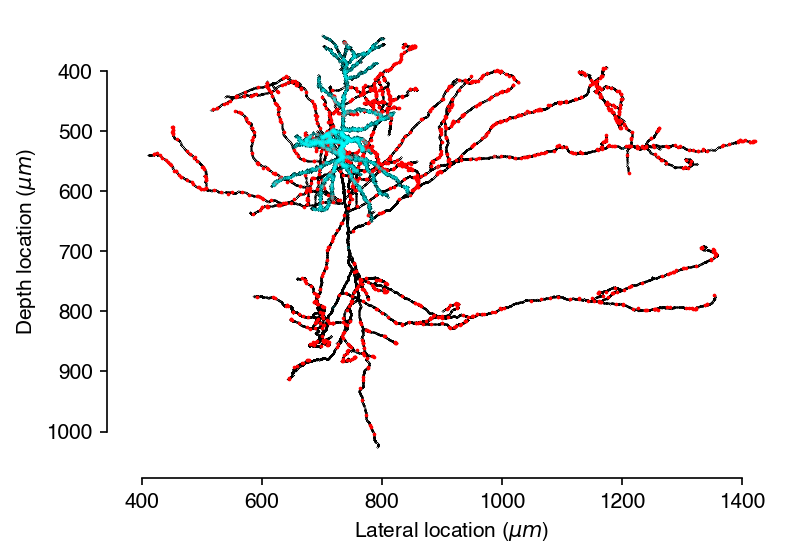

In [21]:
fig, ax = plt.subplots(figsize=(6,4), dpi=150)

ax.plot(
    seed_mesh.vertices[:,0]/1000, # Mesh vertices are in nanometers, so we convert to microns for consistency with previous plots
    seed_mesh.vertices[:,1]/1000,
    linestyle='none',
    marker='.',
    color='k',
    markersize=0.05,
    alpha=0.04,
    zorder=0,
)

# Plot presynaptic synapses
ax.plot(
    np.vstack(pre_syn_df['ctr_pt_position'])[:,0]*voxel_resolution[0]/1000,
    np.vstack(pre_syn_df['ctr_pt_position'])[:,1]*voxel_resolution[1]/1000,
    linestyle='none',
    marker='o',
    color=(1,0,0),
    markersize=0.75,
    alpha=1,
    zorder=1,
)

# Plot postsynaptic synapses
ax.plot(
    np.vstack(post_syn_df['ctr_pt_position'])[:,0]*voxel_resolution[0]/1000,
    np.vstack(post_syn_df['ctr_pt_position'])[:,1]*voxel_resolution[1]/1000,
    linestyle='none',
    marker='o',
    color=(0,1,1),
    markersize=0.1,
    alpha=1,
    zorder=2,
)

ax.invert_yaxis()
ax.set_xlabel('Lateral location ($\mu m$)')
ax.set_ylabel('Depth location ($\mu m$)')
sns.despine(ax=ax, offset=5, trim=True)
ax.set_aspect('equal')

### Figure 5g — Target classes 

Classifying the synaptic targets of this seed cell offers our first example of merging data across the tables. In this case, we want to do two steps:
1) As a quality control step, for every synaptic target of the seed cell, find out how many cell bodies the target has. 
2) For those cells with a single well-defined cell body, determine how many are predicted to be excitatory and inhibitory.

In [22]:
# This step counts how many times a root id appears in the table.
# Since each row is a nucleus, this effectively counts the number of neuronal somata.

soma_count_df = (
    is_neuron_df
        .query('cell_type == "neuron"')
        .groupby('pt_root_id')
        .count()
        .rename(columns={'valid': 'num_soma'})
    )[['num_soma']]

In [23]:
pre_syn_df_cnt = pre_syn_df.merge(
    soma_count_df,
    left_on='post_pt_root_id',
    right_index=True,
    how='left',
).fillna(0)

In [24]:
# Make sure there's only one row per root id. We will ignore cell types for multi-soma merges becuase they
# aren't well defined, so it doesn't matter which gets picked.

ei_df_single = ei_df.drop_duplicates(subset=['pt_root_id'])

target_cat_df = pre_syn_df_cnt.merge(
    ei_df_single[['pt_root_id', 'cell_type']],
    left_on='post_pt_root_id',
    right_on='pt_root_id',
    how='left',
).drop(columns='pt_root_id')

In [25]:
# Get a single category name for each synapse

def _categorize_targets(row):
    if row['num_soma'] == 0:
        return 'orphan'
    elif row['num_soma'] > 1:
        return 'merge error'
    elif pd.isna(row['cell_type']):
        return 'unclassified'
    else: 
        return row['cell_type']

target_cat_df['syn_category'] = target_cat_df.apply(_categorize_targets, axis=1)

syn_cat_dtype=pd.CategoricalDtype(categories=['inhibitory', 'excitatory', 'merge error', 'orphan', 'unclassified'], ordered=True)
target_cat_df['syn_category'] = target_cat_df['syn_category'].astype(syn_cat_dtype)

In [26]:
target_cat_df.groupby('syn_category').count()[['valid']].rename(columns={'valid': 'num cells'})

,num cells
syn_category,
inhibitory,246
excitatory,495
merge error,229
orphan,418
unclassified,10


In [27]:
(418)/1398

0.2989985693848355

In [28]:
target_cat_df.shape

(1398, 13)

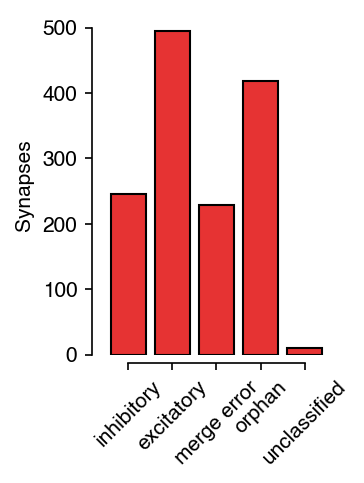

In [29]:
fig, ax = plt.subplots(figsize=(2,3), dpi=150)
sns.histplot(
    x='syn_category',
    data=target_cat_df,
    bins=['excitatory', 'inhibitory', 'orphan', 'merge error'],
    shrink=0.8,
    color=(0.9, 0.2, 0.2),
    alpha=1,
    ax=ax,
    zorder=100,
)
# ax.set_ylim(0,350)
sns.despine(ax=ax, offset=4, trim=True)
ax.set_ylabel('Synapses')
ax.set_xlabel('')
_=plt.xticks(rotation=45)


### Figure 6h — Functionally-matched targets

Next, we're going to use the list of functionally matched cells to find the subset of cells that are both postsynaptic to our seed cell and are matched to functional data.

In [30]:
matched_target_df = pre_syn_df.merge(
    coreg_df,
    left_on='post_pt_root_id',
    right_on='pt_root_id',
    how='inner',
)

matched_target_df[['pt_root_id', 'session', 'scan_idx', 'unit_id']]

,pt_root_id,session,scan_idx,unit_id
0,864691135841206499,4,7,7880
1,864691135490575335,8,5,10211
2,864691136719787630,6,4,4293
3,864691135181716226,6,2,4639


Using the session, scan, and unit_id information, you can follow the instructions from the DataJoint tutorial for how to access relevent functional data for the cells in question.

### Figure 6m — Intermediate feed-forward connections

Here, we want to find cells that both recieve synaptic input from the seed neuron and target one of the four functionally characterized targets above. As an additional step, we will check the proofreading status of the intermediate cells.

In [31]:
pre_syn_df = client.materialize.synapse_query(pre_ids=seed_id)
target_inputs_df = client.materialize.synapse_query(post_ids=matched_target_df['pt_root_id'].values)

pre_edgelist = pre_syn_df.groupby(['pre_pt_root_id', 'post_pt_root_id']).agg({'id': 'count'}).reset_index().rename(columns={'id': 'nsyn_1', 'post_pt_root_id': 'inter_root_id'})
target_edgelist = target_inputs_df.groupby(['pre_pt_root_id', 'post_pt_root_id']).agg({'id': 'count'}).reset_index().rename(columns={'id': 'nsyn_2', 'pre_pt_root_id': 'inter_root_id'})

ff_df = pre_edgelist.merge(target_edgelist, on='inter_root_id')

In [32]:
# Cells with any comprehensive proofreading
all_inter_root_ids = ff_df.merge(pf_df[['pt_root_id']], left_on='inter_root_id', right_on='pt_root_id')['inter_root_id'].values

# Only cells with clean or extended axons or dendrites
pf_inter_root_ids = ff_df.merge(pf_df.query('status_axon in ["clean", "extended"] and status_dendrite in ["clean", "extended"]')[['pt_root_id']], left_on='inter_root_id', right_on='pt_root_id')['inter_root_id'].values

## 3d Visualization in MeshParty/VTK

If you are running this locally, please consider using the 3d visualization in VTK using MeshParty. The code to generate the scene shown in Figure 5f is here is below, but the resulting visualizations are not inline.

In [33]:
# This section sets up an object that helps download and store meshes.

import seaborn as sns

from meshparty import trimesh_vtk, trimesh_io
mm = trimesh_io.MeshMeta(cv_path=client.info.segmentation_source(), disk_cache_path='.', cache_size=0)

#### The seed neuron and its synapses:

In [34]:
ma = trimesh_vtk.mesh_actor(seed_mesh, color=(0,0,0), opacity=1)

# Optional — wireframe mode makes the morphology a little thicker, which often looks better when saving thin processes to a small image file.
ma.GetProperty().SetRepresentationToWireframe()

pre_locs = np.vstack(pre_syn_df['ctr_pt_position'].values) * [4,4,40]
pre_pca = trimesh_vtk.point_cloud_actor(pre_locs, size=3000, color=(1,0,0), opacity=0.5)

post_locs = np.vstack(post_syn_df['ctr_pt_position'].values) * [4,4,40]
post_pca = trimesh_vtk.point_cloud_actor(post_locs, size=1500, color=(0,1,1), opacity=0.5)

cam = trimesh_vtk.oriented_camera(center=seed_mesh.bounding_box.centroid, backoff=2000)
trimesh_vtk.render_actors([ma, pre_pca, post_pca], camera=cam)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer)0x7f9eb213eb80

#### First order targets of our seed neuron:

In [35]:
first_order_ids = np.unique(matched_target_df['pt_root_id'].values)
clrs=sns.husl_palette(s=1, h=0.4, l=0.5)

ma = trimesh_vtk.mesh_actor(seed_mesh, color=(0.9,0.9,0.9), opacity=0.01)
ma.GetProperty().SetRepresentationToWireframe()
cam = trimesh_vtk.oriented_camera(center=seed_mesh.bounding_box.centroid, backoff=2000)

foms = []
for ii, oid in enumerate(first_order_ids):
    fom = mm.mesh(seg_id=oid)
    foma = trimesh_vtk.mesh_actor(fom, color=clrs[1+ii], opacity=1)
    foma.GetProperty().SetRepresentationToWireframe()
    foms.append(foma)

trimesh_vtk.render_actors([ma]+foms, camera=cam)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer)0x7f9e91c2fac0

#### Intermediate feedfoward targets of our seed neuron:

In [36]:
in_clrs = sns.husl_palette(s=1, h=0.8, l=0.7, n_colors=len(pf_inter_root_ids))

ma = trimesh_vtk.mesh_actor(seed_mesh, color=(0.9,0.9,0.9), opacity=0.01)
ma.GetProperty().SetRepresentationToWireframe()
cam = trimesh_vtk.oriented_camera(center=seed_mesh.bounding_box.centroid, backoff=2000)

foms = []
for ii, oid in enumerate(pf_inter_root_ids):
    fom = mm.mesh(seg_id=oid)
    foma = trimesh_vtk.mesh_actor(fom, color=in_clrs[ii], opacity=1)
    foma.GetProperty().SetRepresentationToWireframe()
    foms.append(foma)

trimesh_vtk.render_actors([ma]+foms, camera=cam)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer)0x7f9e920a5700